# YouTube trending videos
Przedmiot: Projekt Eksploracji Danych<br>
Grupa:
* Kajetan Zimniak, 127229
* Bartosz Górka, 127228


## Wczytywanie danych
Projekt zakłada wykorzystanie repozytorium na platformie GitHub i synchronizację plików stanowiących zbiór danych

In [1]:
!git clone --branch feature/textual_attributes https://github.com/bartoszgorka/youtube-trending-videos.git

fatal: destination path 'youtube-trending-videos' already exists and is not an empty directory.


In [0]:
DATA = "youtube-trending-videos/youtube_data"

Sprawdzenie danych przechowywanych w folderze `DATA` (referencja na wcześniej pobrane repozytorium). W wyniku powinniśmy otrzymać listę następujących plików:
* `GB_category_id.json`
* `GB_videos_5p.csv`
* `US_category_id.json`
* `US_videos_5p.csv`

In [3]:
!ls $DATA

GB_category_id.json  GB_videos_5p.csv  US_category_id.json  US_videos_5p.csv


## Import
Import używanych przez program paczek dla języka Python

In [4]:
import os
import re
import json
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import seaborn.apionly as sns
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/usr/local/lib/python3.6/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


True

## Przygotowanie danych pod analizę
Wykorzystujemy `pandas` aby móc efektywnie przeszukiwać nasz zbiór danych zapisany w postaci `DataFrame`

Dane dotyczące kategorii również zostały zaprezentowane w postaci `DataFrame` (normalizacja z oryginalej postaci pliku `JSON`) aby móc ujednolicić wykorzystanie danych.

W przypadku kolumny `description` wymagane było dodatkowe skorygowanie jej nazwy (w pierwotnej występowały nadmiarowe spacje). Dla bezpieczeństwa, operacji zostały poddane wszystkie nazwy kolumn.



In [0]:
def read_and_parse_video_data(name):
    df = pd.read_csv(os.path.join(DATA, name), sep=';', encoding = 'ISO-8859-1')
    df.rename(inplace = True, columns = lambda x: x.strip())
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
    df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    return df

# --------------------------------- GB FILES ---------------------------------
with open(os.path.join(DATA, 'GB_category_id.json')) as json_file:
    GB_category_id = pd.io.json.json_normalize(data = json.load(json_file)['items'])

GB_videos_5p = read_and_parse_video_data('GB_videos_5p.csv')

# --------------------------------- US FILES ---------------------------------
with open(os.path.join(DATA, 'US_category_id.json')) as json_file:
    US_category_id = pd.io.json.json_normalize(data = json.load(json_file)['items'])

US_videos_5p = read_and_parse_video_data('US_videos_5p.csv')

Sprawdzimy teraz, jak prezentuje się ogólna struktura danych dla `GB`

In [6]:
def describe(df, name):
    print(name)
    print(df.info())
    print(df.describe())

describe(GB_category_id, 'GB_category_id')
describe(GB_videos_5p, 'GB_videos_5p')

GB_category_id
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
kind                  31 non-null object
etag                  31 non-null object
id                    31 non-null object
snippet.channelId     31 non-null object
snippet.title         31 non-null object
snippet.assignable    31 non-null bool
dtypes: bool(1), object(5)
memory usage: 1.4+ KB
None
                         kind  ... snippet.assignable
count                      31  ...                 31
unique                      1  ...                  2
top     youtube#videoCategory  ...              False
freq                       31  ...                 17

[4 rows x 6 columns]
GB_videos_5p
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 16 columns):
video_id                  38916 non-null object
trending_date             38916 non-null datetime64[ns]
title                     38916 non-null object
channel_title      

Jak możemy zaobserwować, w naszym zbiorze dla `GB` znajduje się 38916 przykładów. W przypadku 38304 mamy dostępny opis. Świadomie pomijamy znaczenie atrybutów. Ich nazwy wskazują jasno na przechowywaną zawartość.

Sprawdzimy teraz co zawierają w sobie przykłady bez wskazanego opisu.

In [7]:
GB_videos_5p[GB_videos_5p['description'].apply(lambda x: pd.isna(x))]

video_id trending_date  ... video_error_or_removed description
91     _wM_jY_rass    2017-11-14  ...                  False         NaN
118    8HON4AswPVk    2017-11-14  ...                  False         NaN
187    j5AILysDDTI    2017-11-14  ...                  False         NaN
309    _wM_jY_rass    2017-11-15  ...                  False         NaN
336    8HON4AswPVk    2017-11-15  ...                  False         NaN
...            ...           ...  ...                    ...         ...
38511  H08xgoXkpa8    2018-06-12  ...                  False         NaN
38560  vjSohj-Iclc    2018-06-12  ...                  False         NaN
38639  JXZG_Qcm6Nw    2018-06-13  ...                  False         NaN
38735  vjSohj-Iclc    2018-06-13  ...                  False         NaN
38815  JXZG_Qcm6Nw    2018-06-14  ...                  False         NaN

[612 rows x 16 columns]

Postanowiliśmy zastąpić wartość pustą w opisach wartością `""` tj. pustym ciągiem znaków. Taki zabieg pozwali nam na zachowanie przykładów.

In [0]:
GB_videos_5p['description'] = GB_videos_5p['description'].fillna(value='')

Również dla danych z `US` podjęto podobną analizę.

In [9]:
describe(US_category_id, 'US_category_id')
describe(US_videos_5p, 'US_videos_5p')

US_category_id
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
kind                  32 non-null object
etag                  32 non-null object
id                    32 non-null object
snippet.channelId     32 non-null object
snippet.title         32 non-null object
snippet.assignable    32 non-null bool
dtypes: bool(1), object(5)
memory usage: 1.4+ KB
None
                         kind  ... snippet.assignable
count                      32  ...                 32
unique                      1  ...                  2
top     youtube#videoCategory  ...              False
freq                       32  ...                 17

[4 rows x 6 columns]
US_videos_5p
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null datetime64[ns]
title                     40949 non-null object
channel_title      

In [0]:
US_videos_5p['description'] = US_videos_5p['description'].fillna(value='')

W dalszej analizie przeprowadzimy połączenie obu zbiorów danych z zaznaczeniem skąd pochodzą przykłady. Taka informacja może się nam przydać dla dalszego wnioskowania. Może występować sytuacja, że dla Wielkiej Brytanii zalecimy inną strategię, niż w przypadku Stanów Zjednoczonych.

In [0]:
US_videos_5p['country_code'] = 'US'
GB_videos_5p['country_code'] = 'GB'
content = pd.concat([GB_videos_5p, US_videos_5p])

# Etap 1 - Atrybuty tekstowe
Wstępne statystyki danych, wykorzystanie metod wizualizacji, zapoznanie się z danymi oraz ich jakością; identyfikacja braków
* Zmiana reprezentacji danych: atrybuty oparte na opisie, tytule i ewentualnie innych atrybutach (bez obrazków)
    * Występowanie słów (jakie słowa są szczególnie informatywne dla naszego problemu?)
    * Atrybuty oparte na tytułach i opisach: długość, interpunkcja, wielkie litery, obecność linków itp.
    * Czas uploadu do YouTube
    * Jakie atrybuty da się wykorzystać? Jakich nie? Dlaczego?
* OCENA (15%)
    * 5% podsumowanie danych, wstępne statystyki
    * 5% atrybuty tekstowe (semantyka)
    * 5% atrybuty tekstowe (meta)

Do naszego zbioru wprowadzimy parę nowych atrybutów, które być może będą dobrym wyznacznikiem postępowania.

Rozpoczniemy od stosunku liczby polubień i wskazania braku akceptacji w stosunku do liczby wyświetleń. Do tego skupimy się także na komentarzach. Wykorzystując te dane możemy wnioskować o reakcji odbiorców na materiał video.

Spodziewamy się możliwości wyeliminowania bazowych danych w postaci liczby polubień oraz liczby łapek w dół, a także komentarzy. Sądzimy, że wprowadzenie stosunku reakcji do liczby wyświetleń pozwoli na "ujednolicenie" tej miary pomiędzy różnymi filmami.

In [0]:
content['likes_per_view'] = content['likes'] / content['views']
content['dislikes_per_views'] = content['dislikes'] / content['views']

content['likes_dislikes_ratio'] = content['likes'] / content['dislikes']

content['comments_per_view'] = content['comment_count'] / content['views']
content['reactions_per_view'] = (content['likes'] + content['dislikes']) / content['views']
content['all_reactions_per_view'] = (content['likes'] + content['dislikes'] + content['comment_count']) / content['views']

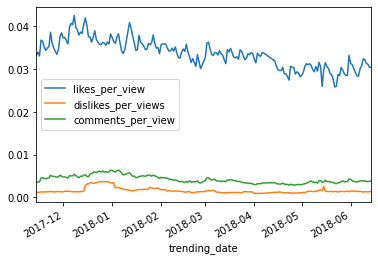

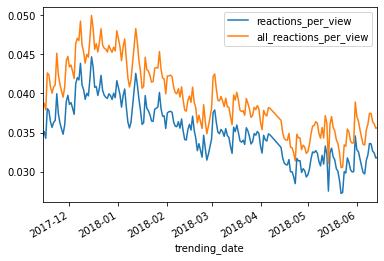

In [13]:
pivot_table = pd.pivot_table(content[content['country_code'] == 'GB'], index = content[content['country_code'] == 'GB'].trending_date)
_ = pivot_table[['likes_per_view','dislikes_per_views', 'comments_per_view']].plot()
_ = pivot_table[['reactions_per_view', 'all_reactions_per_view']].plot()

W reakcjach użytkowników zdecydowanie przeważają polubienia. Liczba komentarzy przypadająca na wyświetlenie jest nieznacznie większa od liczby łapek w dół, jednak znacznie mniejsza niż polubienia.

Więcej informacji dostarcza nam wykres łączny interacji w stosunku do wyświetleń. Obserwujemy tutaj spadek wraz z upływem czasu. W okolicach stycznia 2018 było najwięcej reakcji użytkowników, później wraz z czasem liczba ta spadała.

Po przygotowaniu reakcji skupimy się na danych czasowych. W przypadku wskazania `trending date` mamy dostęp wyłącznie do daty bez godziny (tego dnia zaobserwowano obecność video na liście "gorących tematów").

Bardziej przydatne w naszym przypadku może być rozdzielenie daty i godziny publikacji na dwa atrybuty. Intuicja podpowiada, że najprawdopodobniej warto publikować w godzinach aktywności odbiorców. Pozwala to osiągnąć dużą oglądalność już chwilę po publikacji, co może być nagradzane przez algorytm wybierający materiały video na listę trending.

In [0]:
content['published_at_date'] = content['publish_time'].dt.date
content['published_at_time'] = content['publish_time'].dt.time
content['published_day_of_week'] = content['publish_time'].dt.day_name()

Bazując na powyższych danych, postanowiliśmy sprawdzić wpływ dnia tygodnia oraz godziny na liczbę wyświetleń filmu.

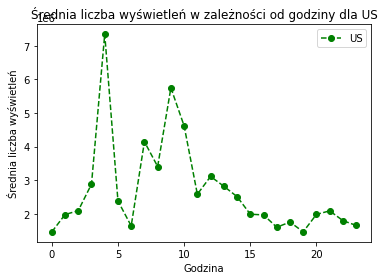

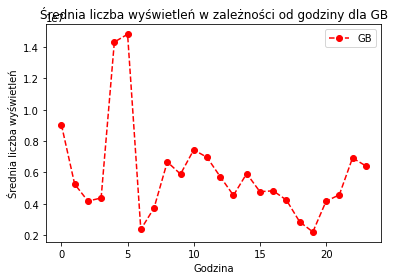

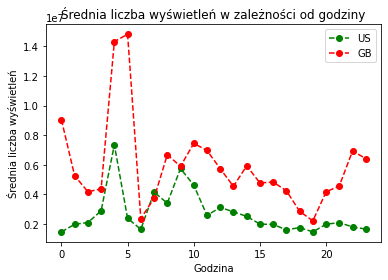

In [15]:
content['published_at_hour'] = content['publish_time'].dt.hour
by_hour_US = content[content['country_code'] == 'US'].groupby('published_at_hour').mean()
by_hour_GB = content[content['country_code'] == 'GB'].groupby('published_at_hour').mean()

def show_by_hour(df, name, color = 'green'):
    plt.plot(df.index.values, df['views'], marker='o', linestyle = '--', color=color, label = name)
    plt.xlabel('Godzina')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od godziny dla ' + name)
    plt.legend()
    plt.show()

def show_by_hour_both(us, gb):
    plt.plot(us.index.values, us['views'], marker='o', linestyle = '--', color='green', label = 'US')
    plt.plot(gb.index.values, gb['views'], marker='o', linestyle = '--', color='red', label = 'GB')
    plt.xlabel('Godzina')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od godziny')
    plt.legend()
    plt.show()

show_by_hour(by_hour_US, 'US')
show_by_hour(by_hour_GB, 'GB', color = 'red')
show_by_hour_both(by_hour_US, by_hour_GB)

Zgodnie z naszymi oczekiwaniami, występują pewne trendy jeżeli chodzi o liczbę wyświetleń. Zarówno dla US, jak i GB są godziny gdy publikowany film osiąga większą liczbę wyświetleń.

Całość może być spowodowana dzienną rutyną użytkowników tj. oglądanie materiałów przed pracą oraz po niej. W przypadku US wpływ godzin wydaje się być mniejszy niż dla GB - jednakże może to być spowodowane wielkością kraju i występowaniem czterech stref czasowych.

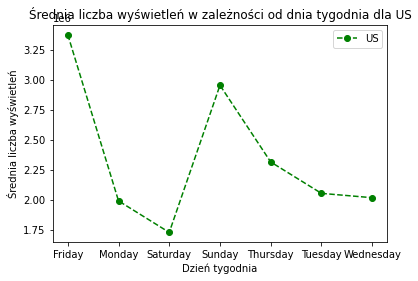

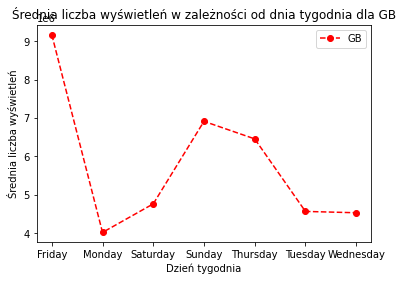

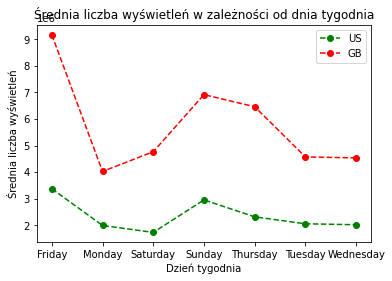

In [16]:
day_of_week_US = content[content['country_code'] == 'US'].groupby('published_day_of_week').mean()
day_of_week_GB = content[content['country_code'] == 'GB'].groupby('published_day_of_week').mean()

def show_day_of_week(df, name, color = 'green'):
    plt.plot(df.index.values, df['views'], marker='o', linestyle = '--', color=color, label = name)
    plt.xlabel('Dzień tygodnia')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od dnia tygodnia dla ' + name)
    plt.legend()
    plt.show()

def show_day_of_week_both(us, gb):
    plt.plot(us.index.values, us['views'], marker='o', linestyle = '--', color='green', label = 'US')
    plt.plot(gb.index.values, gb['views'], marker='o', linestyle = '--', color='red', label = 'GB')
    plt.xlabel('Dzień tygodnia')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od dnia tygodnia')
    plt.legend()
    plt.show()

show_day_of_week(day_of_week_US, 'US')
show_day_of_week(day_of_week_GB, 'GB', color = 'red')
show_day_of_week_both(day_of_week_US, day_of_week_GB)

Dokonując analizy dni tygodnia możemy dojść do wniosku o zwiększonym zainteresowaniu w piątek oraz w niedzielę. Trend rozpoczyna się już w czwartek - ludzie przed rozpoczęciem weekendu pragną chociaż na chwilę oderwać się od pracy. Gwałtowny spadek mamy w przypadku poniedziałku - skupienie na obowiązkach oraz mniejsza ilość wolnego czasu redukują zainteresowanie materiałami video.

Pojawienie się w zbiorze promowanych filmów (trending) jest na pewno pewnym osiągnięciem. Analizując zbiór danych natrafiliśmy na wielokrotne wystąpienie pewnych filmów i wskazanie, że utrzymywały się one dłużej niż jeden dzień w zestawieniu.

Postanowiliśmy sprawdzić jak wygląda rozkład długości przebywania filmu w ramach grupy trending.

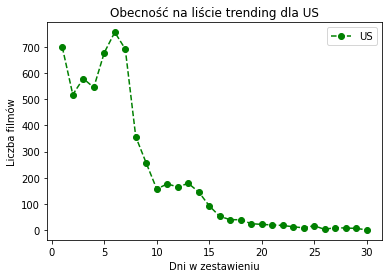

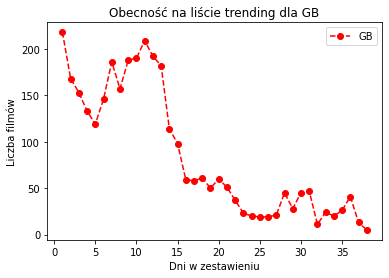

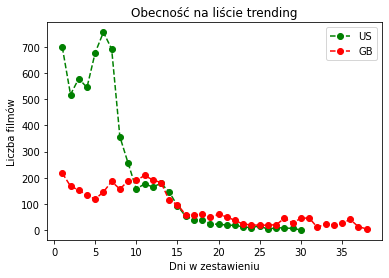

In [17]:
trending_time_US = content[(content['country_code'] == 'US') & (content['video_id'] != '#NAZWA?')].groupby('video_id')['video_id'].agg(count_col=pd.NamedAgg(column='video_id', aggfunc='count')).groupby('count_col').agg(days=pd.NamedAgg(column='count_col', aggfunc='count'))
trending_time_GB = content[(content['country_code'] == 'GB') & (content['video_id'] != '#NAZWA?')].groupby('video_id')['video_id'].agg(count_col=pd.NamedAgg(column='video_id', aggfunc='count')).groupby('count_col').agg(days=pd.NamedAgg(column='count_col', aggfunc='count'))

def show_trending_duration(df, name, color = 'green'):
    plt.plot(df.index.values, df['days'], marker='o', linestyle = '--', color=color, label = name)
    plt.xlabel('Dni w zestawieniu')
    plt.ylabel('Liczba filmów')
    plt.title('Obecność na liście trending dla ' + name)
    plt.legend()
    plt.show()

def show_trending_duration_both(us, gb):
    plt.plot(us.index.values, us['days'], marker='o', linestyle = '--', color='green', label = 'US')
    plt.plot(gb.index.values, gb['days'], marker='o', linestyle = '--', color='red', label = 'GB')
    plt.xlabel('Dni w zestawieniu')
    plt.ylabel('Liczba filmów')
    plt.title('Obecność na liście trending')
    plt.legend()
    plt.show()

show_trending_duration(trending_time_US, 'US')
show_trending_duration(trending_time_GB, 'GB', color = 'red')
show_trending_duration_both(trending_time_US, trending_time_GB)

Obserwujemy tutaj naprawdopodobniej błąd w zbiorze danych dostarczonych w zadaniu. Jako `video_id` pojawia się `#NAZWA?` zamiast poprawnego identyfikatora filmu. W dalszych etapach projektu będzie trzeba podjąć decyzję o przyszłości przykładów z tą wartością.

Najwięcej filmów pojawia się w zestawieniu przez krótki czas rzędu od jednego dnia do maksymalnie 10. Możemy natrafić także na rekordzistów w postaci aż 38 dni, jednakże jest to bardzo nieliczna grupa.

Analizując dalej dostepne atrybuty, postanowiliśmy dodać kolejne atrybuty bazujące na atrybutach tekstowych. W pierwszej fazie skupiliśmy się na tytule oraz słowach kluczowych (tagach) użytych do opisu filmu.

In [0]:
stopwords = set(nltk.corpus.stopwords.words('english'))

content['total_words_title'] = content['title'].apply(lambda x: len(str(x).split()))
content['total_words_tags'] = content['tags'].apply(lambda x: len(str(x).split("|")))

content['total_unique_words_title'] = content['title'].apply(lambda x: len(set(str(x).split())))
content['total_unique_words_tags'] = content['tags'].apply(lambda x: len(set(str(x).replace("\"","").split("|"))))

content['total_letters_title'] = content['title'].apply(lambda x: len(str(x)))
content['total_letters_tags'] = content['tags'].apply(lambda x: len(str(x).replace("|","").replace("\"","")))

content['total_punctuations_title'] = content['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
content['total_punctuations_tags'] = content['tags'].apply(lambda x: len([c for c in str(x).replace("|","") if c in string.punctuation]))

content['total_words_upper_title'] = content['title'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
content['total_words_upper_tags'] = content['tags'].apply(lambda x: len([w for w in str(x).replace("\"","").split("|") if w.isupper()]))

content['total_words_title_title'] = content['title'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
content['total_words_title_tags'] = content['tags'].apply(lambda x: len([w for w in str(x).replace("\"","").split('|') if w.istitle()]))

content['total_stopwords_title'] = content['title'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
content['total_stopwords_tags'] = content['tags'].apply(lambda x: len([w for w in str(x).lower().replace("\"","").split('|') if w in stopwords]))

content['mean_word_length_title'] = content['title'].apply(lambda x: np.mean([len(w) for w in str(x).split()]).round(decimals=0))
content['mean_word_length_tags'] = content['tags'].apply(lambda x: np.mean([len(w) for w in str(x).replace("\"","").split('|')]).round(decimals=0))

Poniżej prezentujemy serię wykresów, które pozwalają sprawdzić jak wyglądają rozkłady dla poszczególnych atrybutów.

In [0]:
def plot_distribution(df, attr, attr_name, n=150):
    plt.figure(figsize=(25,5))
    plt.xticks(rotation=90)
    group = df.groupby(attr)[attr].agg(res=pd.NamedAgg(column=attr, aggfunc='count'))
    ax = sns.barplot(x=group.index.values[0:n], y='res', data=group.head(n)).set(
      xlabel=attr_name, 
      ylabel='Ilość wystąpień'
    )

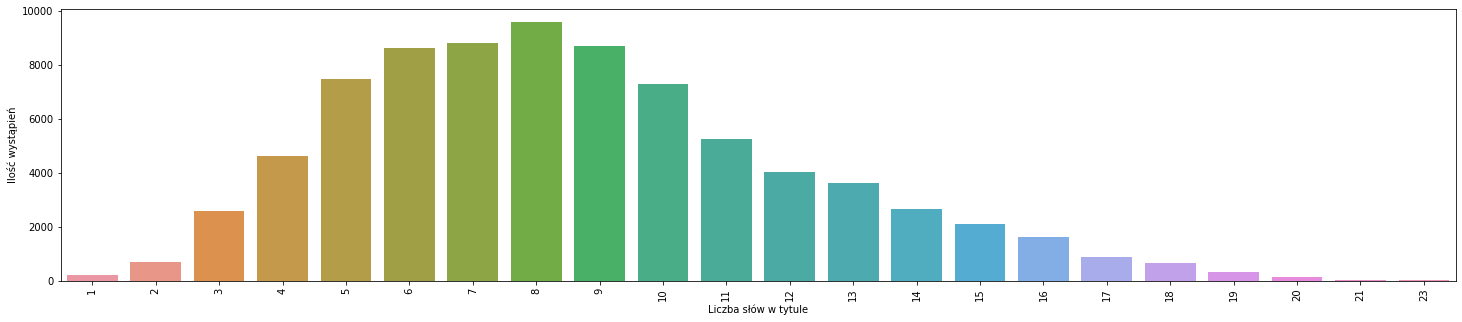

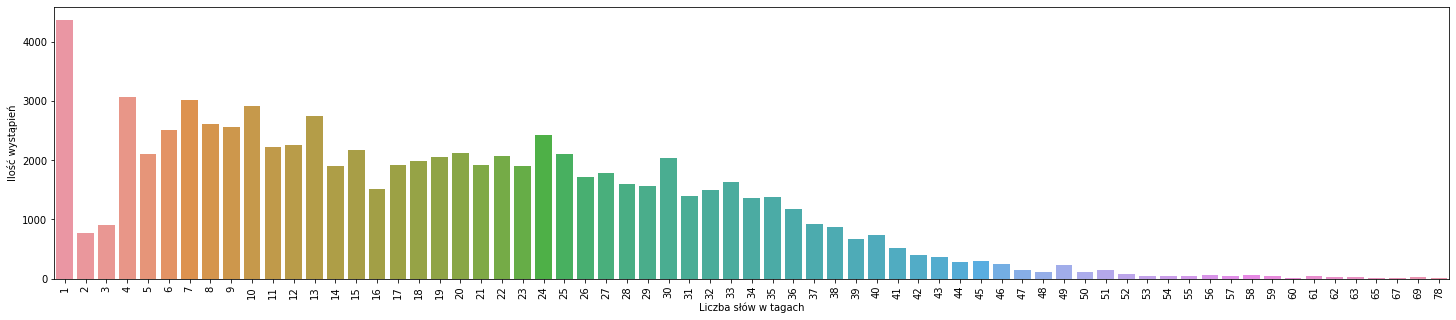

In [20]:
plot_distribution(content, 'total_words_title', 'Liczba słów w tytule')
plot_distribution(content, 'total_words_tags', 'Liczba słów w tagach')

W filmach dominują tytuły zawierajace od 4 do 12 słów (najczęściej 8 słów). Taka wartość jest wystarczająca przy przekazać ogólną ideę oraz zainteresować widza, jednocześnie nie zajmując zbyt dużo miejsca na ekranie.

W przypadku tagów filmy zawierają albo jeden główny tag, albo wiele tagów.

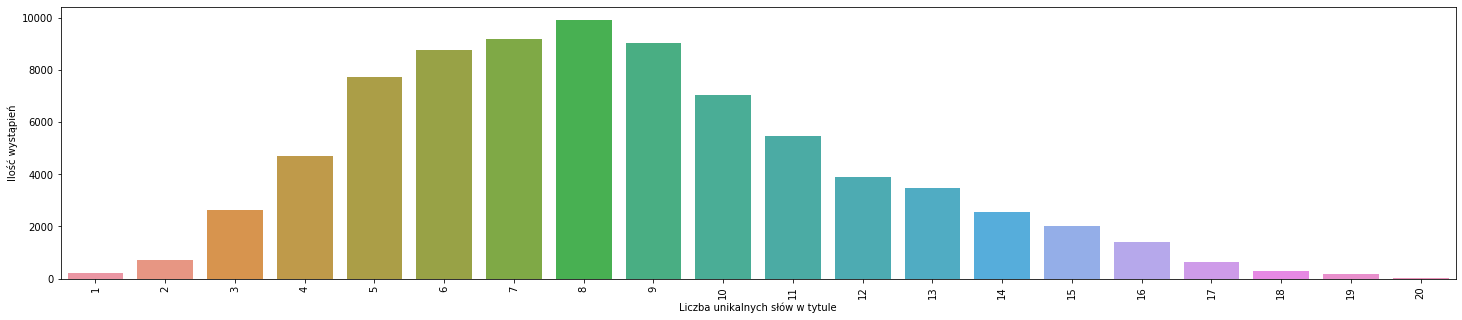

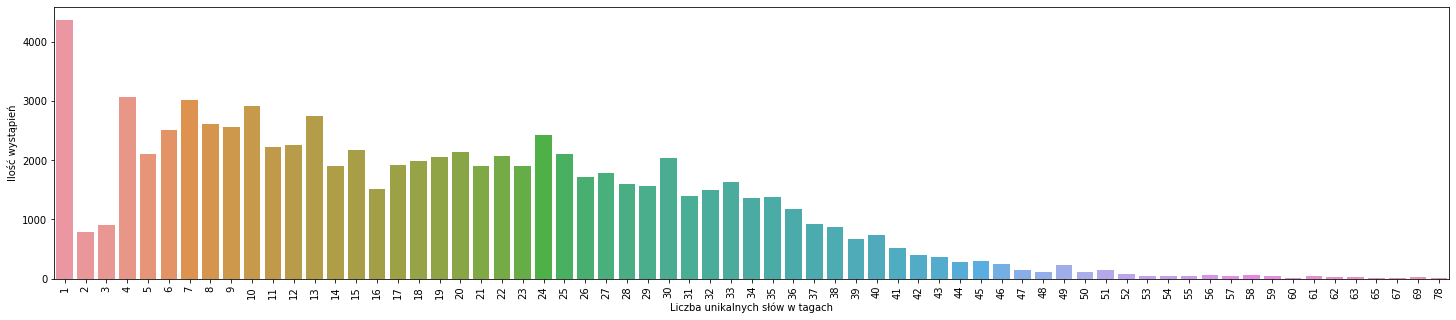

In [21]:
plot_distribution(content, 'total_unique_words_title', 'Liczba unikalnych słów w tytule')
plot_distribution(content, 'total_unique_words_tags', 'Liczba unikalnych słów w tagach')

Zarówno dla tytułu jak i słów kluczowych nie stosuje się powtórzeń - ogromna większość wyrazów jest unikalna.

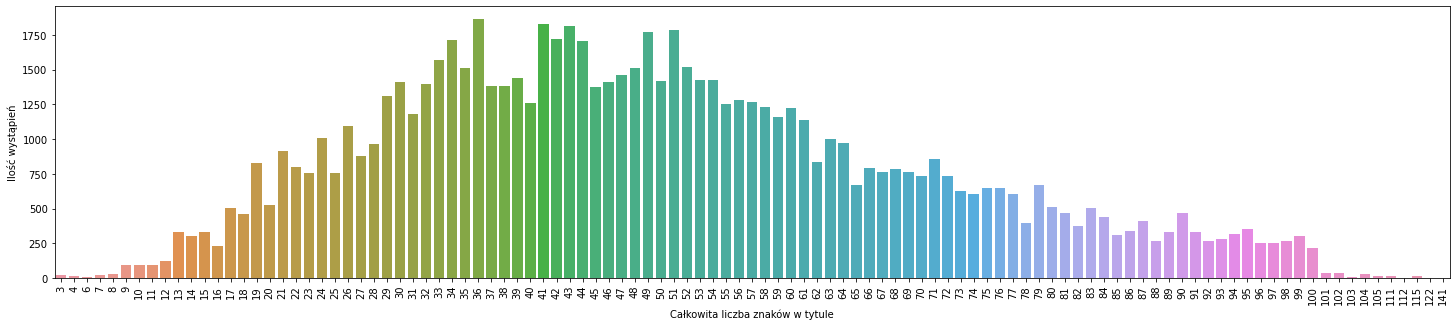

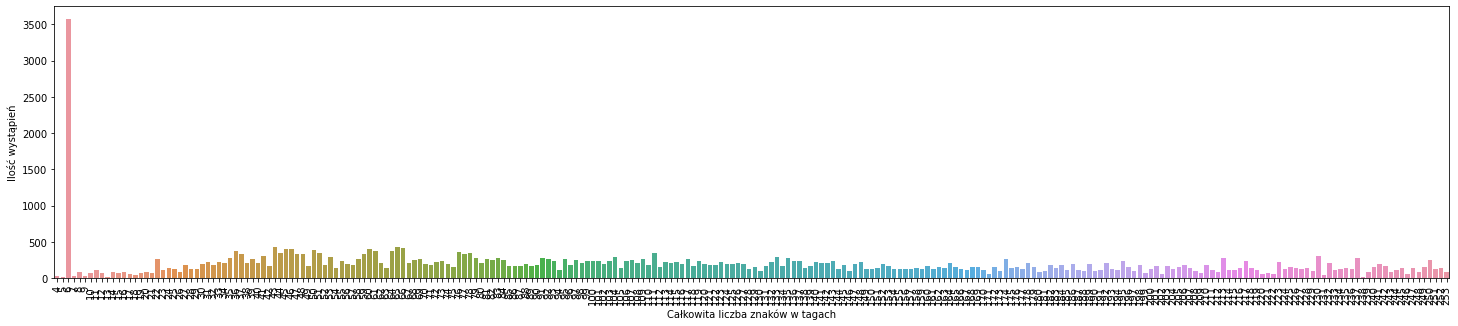

In [22]:
plot_distribution(content, 'total_letters_title', 'Całkowita liczba znaków w tytule', n=250)
plot_distribution(content, 'total_letters_tags', 'Całkowita liczba znaków w tagach', n=250)

Całkowita liczba znaków w przypadku tytułu mieści się w zakresie od 13 do 100 z dominacją w zakresie 35-50. Taka liczba znaków pozwala przekazać informacje, a nie jest zbyt duża.

Inną sytuację obserwujemy dla tagów. Tutaj praktycznie możemy powiedzieć o rozkładzie zbliżonym do normalnego z pewnym pikiem na początku. Najczęściej tagi są krótkie a dalsze ich rozszrzanie może okazać się bezcelowe.

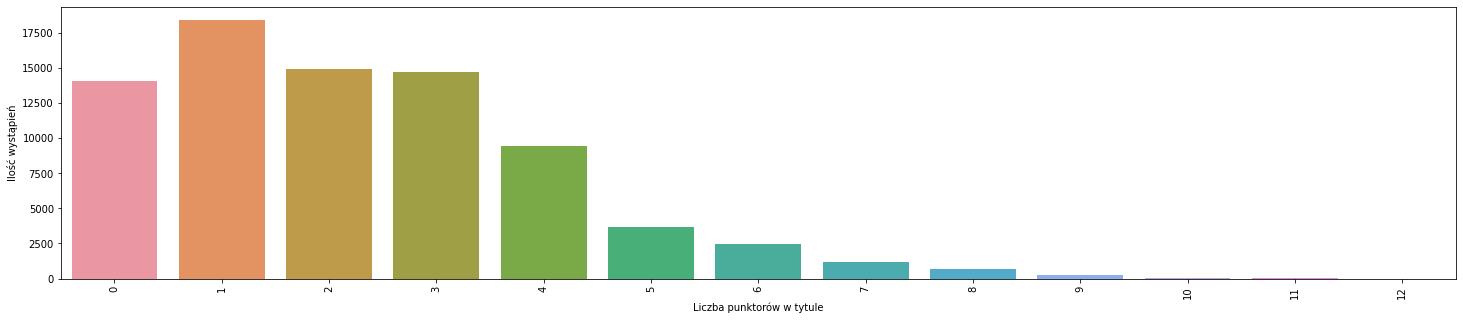

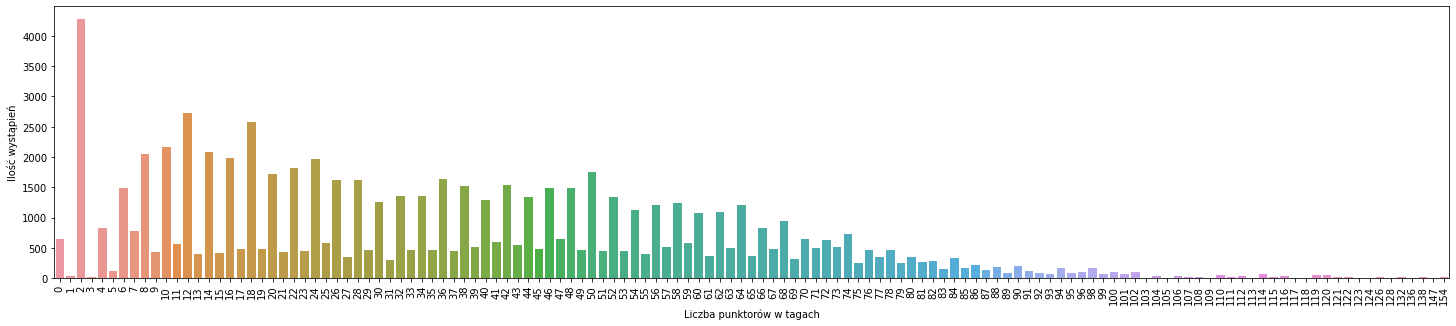

In [23]:
plot_distribution(content, 'total_punctuations_title', 'Liczba punktorów w tytule')
plot_distribution(content, 'total_punctuations_tags', 'Liczba punktorów w tagach')

W przypadku tytułów bardzo często nie stosuje się w ogóle, albo stosuje w ograniczonym zakresie punktory takie jak `?`, `!` czy `.` Wzbudzenie emocji (wielokrotne `!`), zainteresowanie (wykorzystanie `?`) czy urwanie wypowiedzi i skłonienie do obejrzenia materiału (użycie `...`) jest popularnym zabiegiem dla promocji filmów.

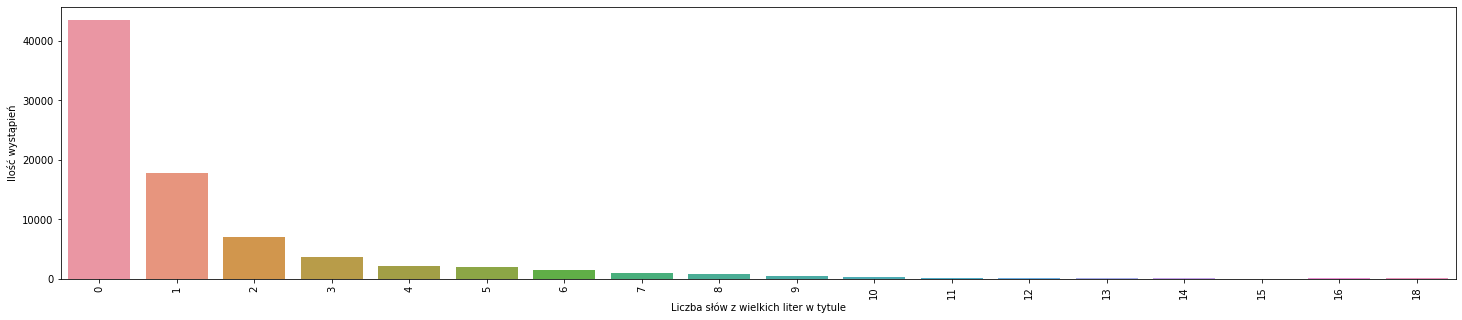

In [24]:
plot_distribution(content, 'total_words_upper_title', 'Liczba słów z wielkich liter w tytule')

Liczba słów z wielkich liter ogranicza się co nawyżej do paru. Używanie takich słów może być uznane zgodne z netykietą za "krzyk", co nie jest pożądane.

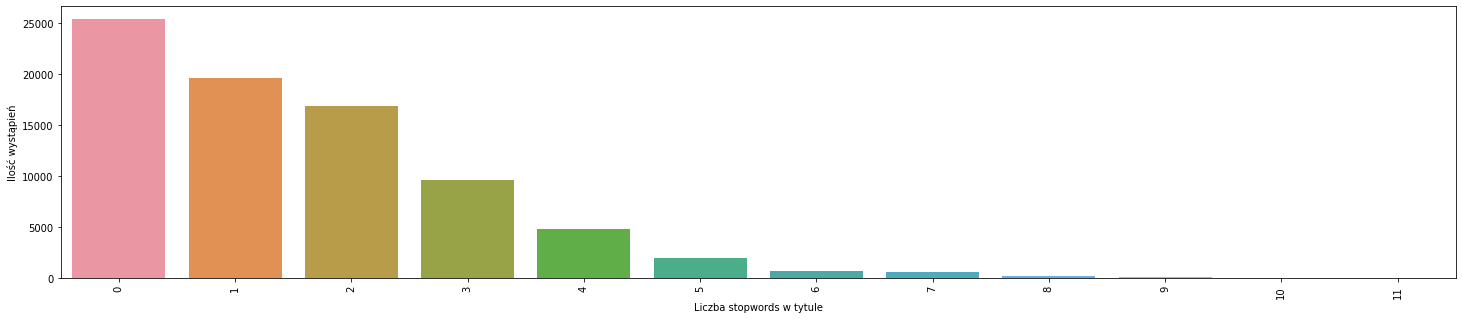

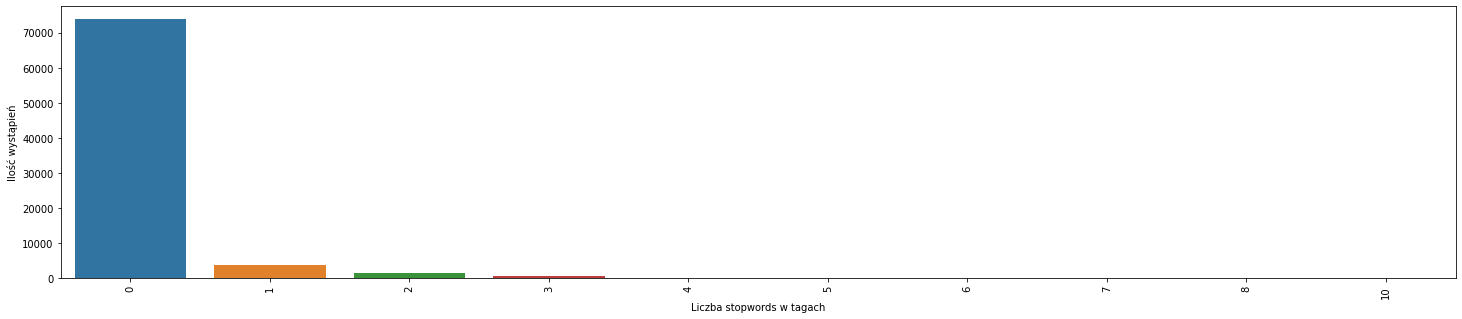

In [25]:
plot_distribution(content, 'total_stopwords_title', 'Liczba stopwords w tytule')
plot_distribution(content, 'total_stopwords_tags', 'Liczba stopwords w tagach')

W przypadku słów kluczowych przewaga nie używania stopwords jest bardziej widoczna niż w przypadku tytułów. Popularne wyrażenia typu `a`, `an`, `the`, `not` mogą często pojawiać się jako niezbędna część wyrażenia. W przypadku `the` mamy jeszcze wpływ użycia przy nazwach jak chociażby `The Guardian`.

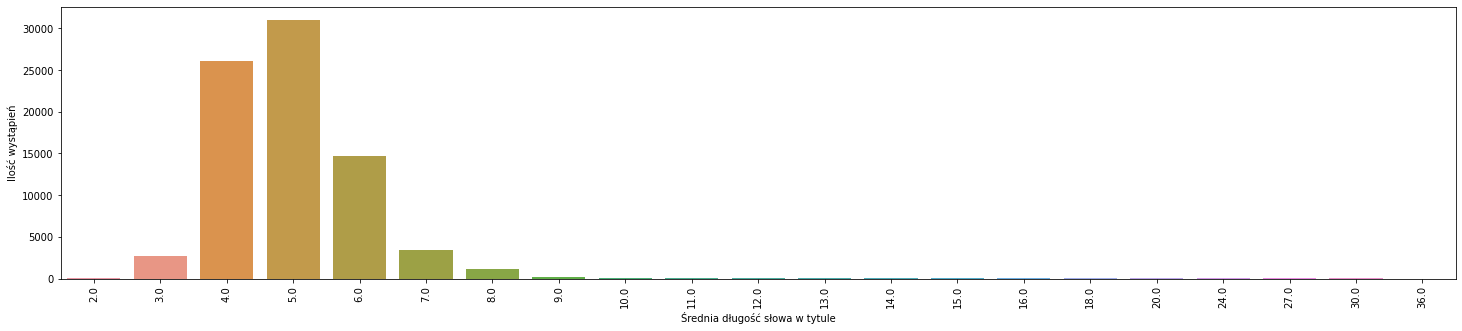

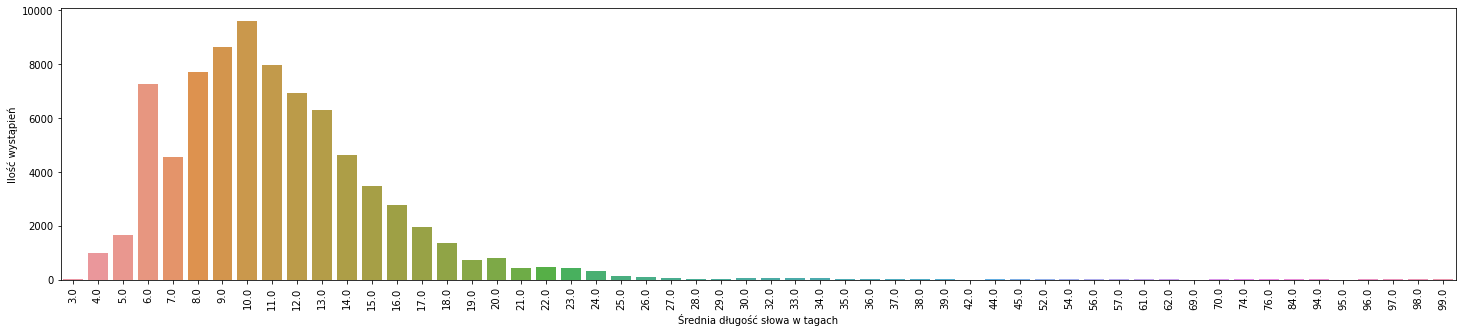

In [26]:
plot_distribution(content, 'mean_word_length_title', 'Średnia długość słowa w tytule')
plot_distribution(content, 'mean_word_length_tags', 'Średnia długość słowa w tagach')

Dla tytułów dominują krótkie słowa mające po 4 do 6 znaków. Pojawiają się też dłuższe określenia, jednakże są one niezbyt liczne. W przypadku tagów mamy całkowicie inną sytuacje. Dla słów kluczowych dominują dłuższe zwroty opisujące całe wydarzenia, uroczystości np. `Christmas`.

Po analizie danych tekstowych oraz informacji, które można zbudować na podstawie oryginalnie dostarczonych opisów, postanowiliśmy sprawdzić opisy boolowskie.

In [27]:
no_duplicated = content.drop_duplicates(subset='video_id', keep='first', inplace=False)
no_duplicated[no_duplicated['country_code'] == 'US'].select_dtypes(include=[np.bool]).apply(pd.Series.value_counts, normalize=True, dropna=False)

comments_disabled  ratings_disabled  video_error_or_removed
False           0.983504          0.996018                0.999621
True            0.016496          0.003982                0.000379

Jak możemy zaobserwować w tabeli powyżej (znormalizowana, suma w kolumnie wynosi 1.0) ogromną przewagę mają filmy, które nie zablokowały komentarzy ani oceny. Takie podejście jest w pełni zrozumiałe - umożlwienie wyrażenia swojej opinii, ocenienia materiału wpływa pozytywnie na odbiór.

W przypadku części materałów doszło do ich usunięcia lub innego błędu. Mogło to być spowodowane naruszeniami praw autorskich lub innymi działaniami niezgodnymi z regulaminem. Również mogło dojść do wycofania materiału przez autora. Szczegóły w tej sytuacji wymagają sprawdzenia indywidualnego każdego z materiałów oznaczonych `video_error_or_removed = True` co nie jest przedmiotem powyższej analizy.

In [28]:
no_duplicated[no_duplicated['country_code'] == 'GB'].select_dtypes(include=[np.bool]).apply(pd.Series.value_counts, normalize=True, dropna=False)

comments_disabled  ratings_disabled  video_error_or_removed
False           0.983627          0.995057                0.998455
True            0.016373          0.004943                0.001545

Podobnie jak dla Stanów Zjednoczonych, również w przypadku Wielkiej Brytanii mamy podobne charakterystyki jeżeli chodzi o zablokowanie ocen i komentarzy a także usunięcia filmów.

Analizując dalej nasze atrybuty tekstowe, skupiliśmy się na charakterystyce najczęściej występujących słów w tytuł, opisach oraz tagach.

In [0]:
def plt_word_cloud(data):
    wc = WordCloud(width=1200, height=500, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15,10))
    plt.imshow(wc, interpolation='bilinear')
    _ = plt.axis("off")

def frequency_words(df, n=100):
    lower_title = df.str.lower().str.cat(sep=' ')
    only_words = re.sub('[^A-Za-z]+', ' ', lower_title)
    stop_words = set(nltk.corpus.stopwords.words('english'))

    word_tokens = word_tokenize(only_words)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    words_without_single_character = [word for word in filtered_sentence if len(word) > 2]
    no_numeric = [word for word in words_without_single_character if not word.isnumeric()]

    word_dist = nltk.FreqDist(no_numeric)
    rslt = pd.DataFrame(word_dist.most_common(n), columns=['word', 'freq'])

    plt.figure(figsize=(20, 10))
    plt.xticks(rotation=90)
    ax = sns.barplot(x='word', y='freq', data=rslt.head(int(n/2))).set(
      xlabel='Słowo', 
      ylabel='Ilość wystąpień'
    )

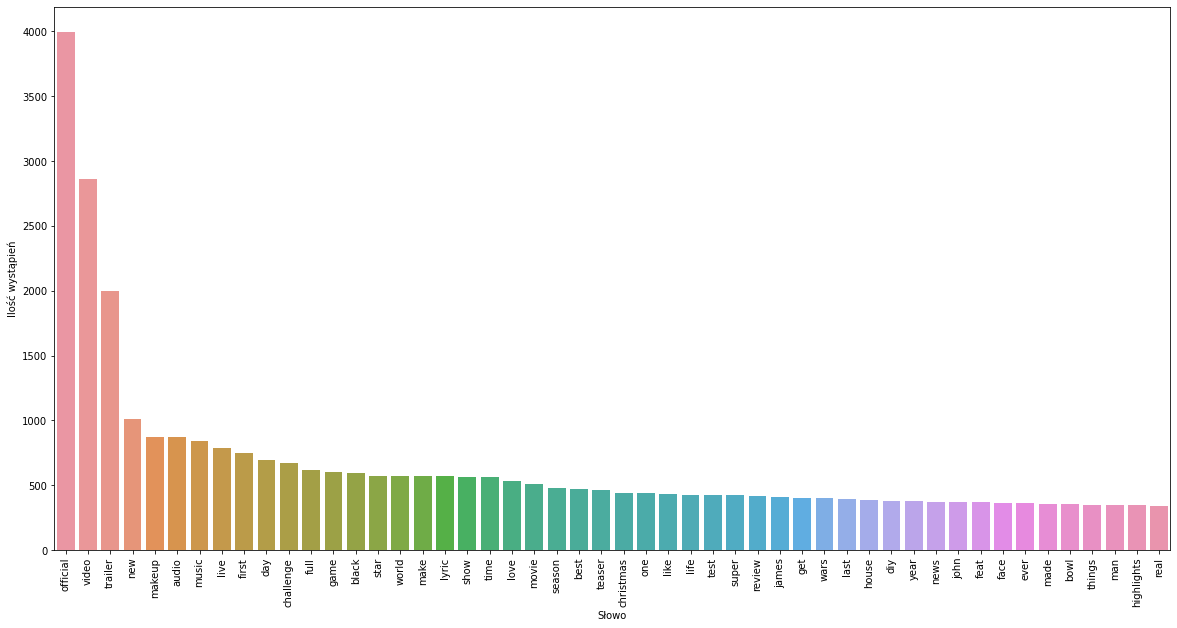

In [34]:
frequency_words(content[content['country_code'] == 'US']['title'])

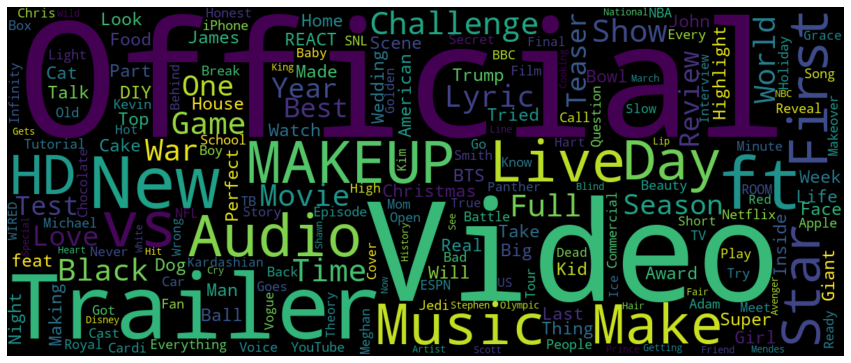

In [35]:
plt_word_cloud(content[content['country_code'] == 'US']['title'])

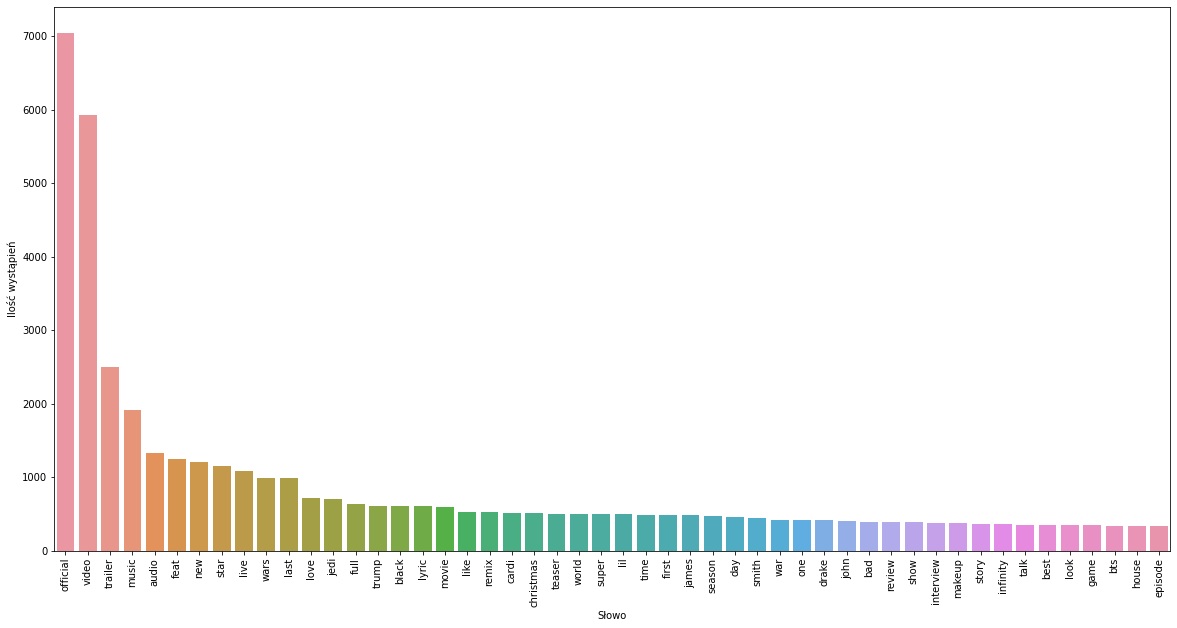

In [36]:
frequency_words(content[content['country_code'] == 'GB']['title'])

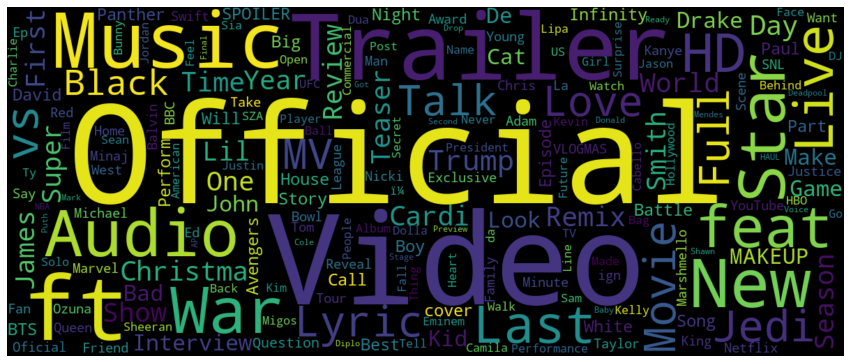

In [37]:
plt_word_cloud(content[content['country_code'] == 'GB']['title'])

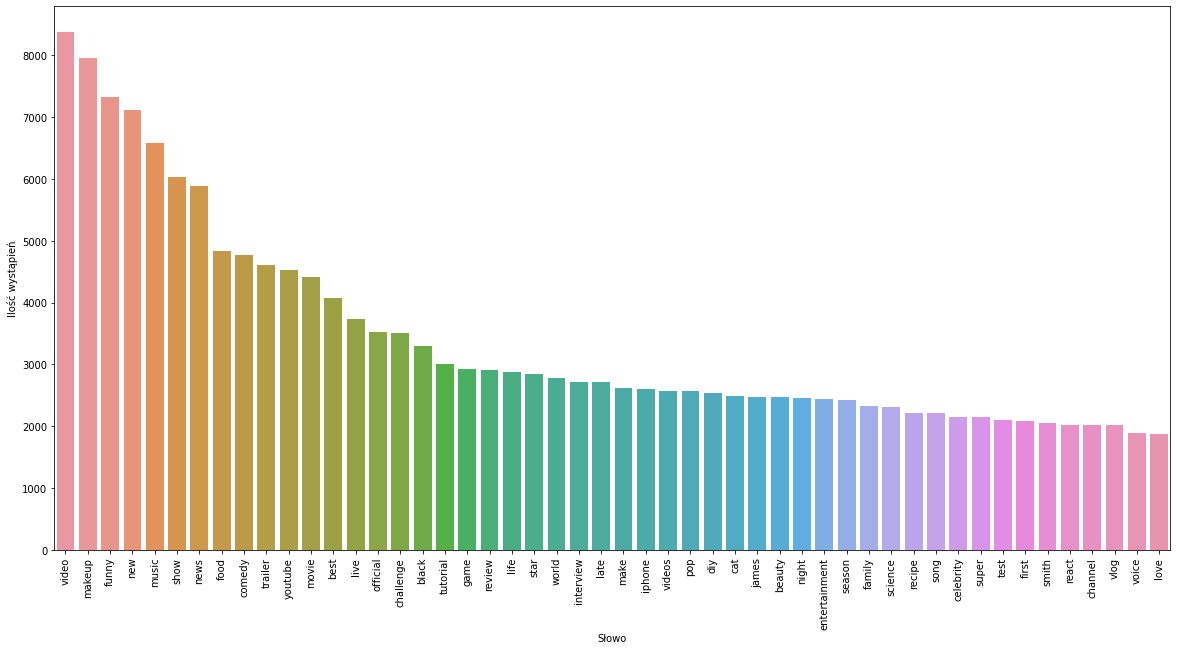

In [38]:
frequency_words(content[content['country_code'] == 'US']['tags'])

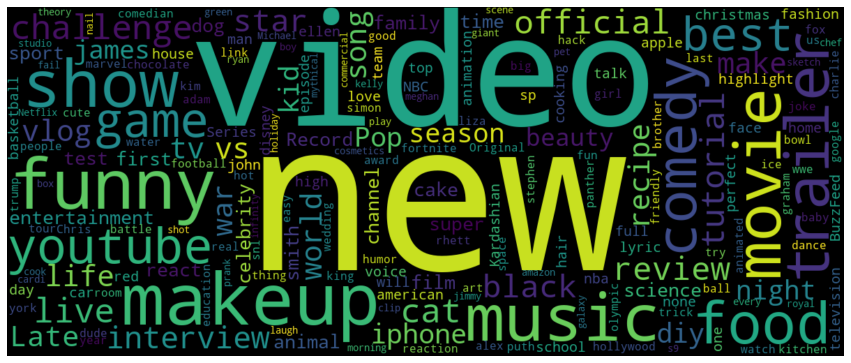

In [39]:
plt_word_cloud(content[content['country_code'] == 'US']['tags'])

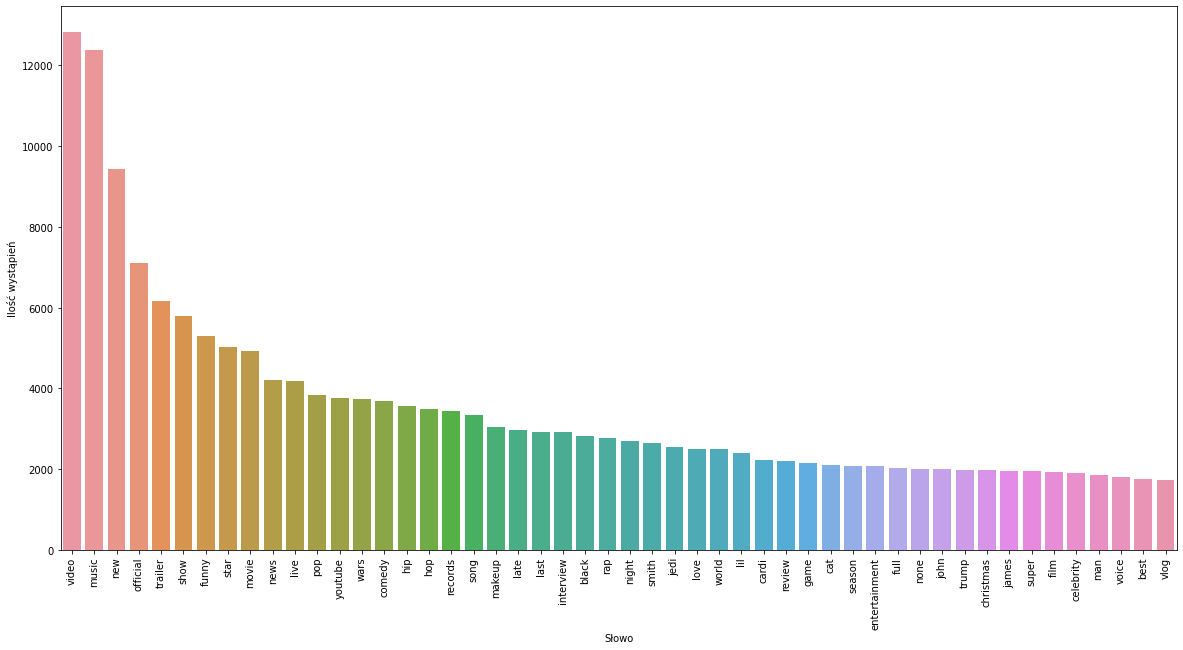

In [40]:
frequency_words(content[content['country_code'] == 'GB']['tags'])

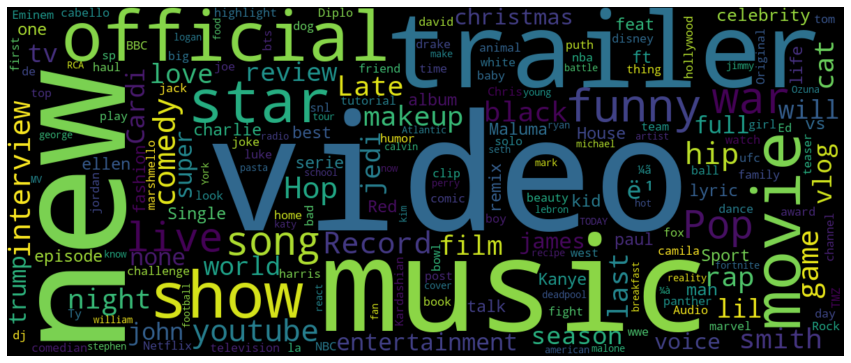

In [41]:
plt_word_cloud(content[content['country_code'] == 'GB']['tags'])

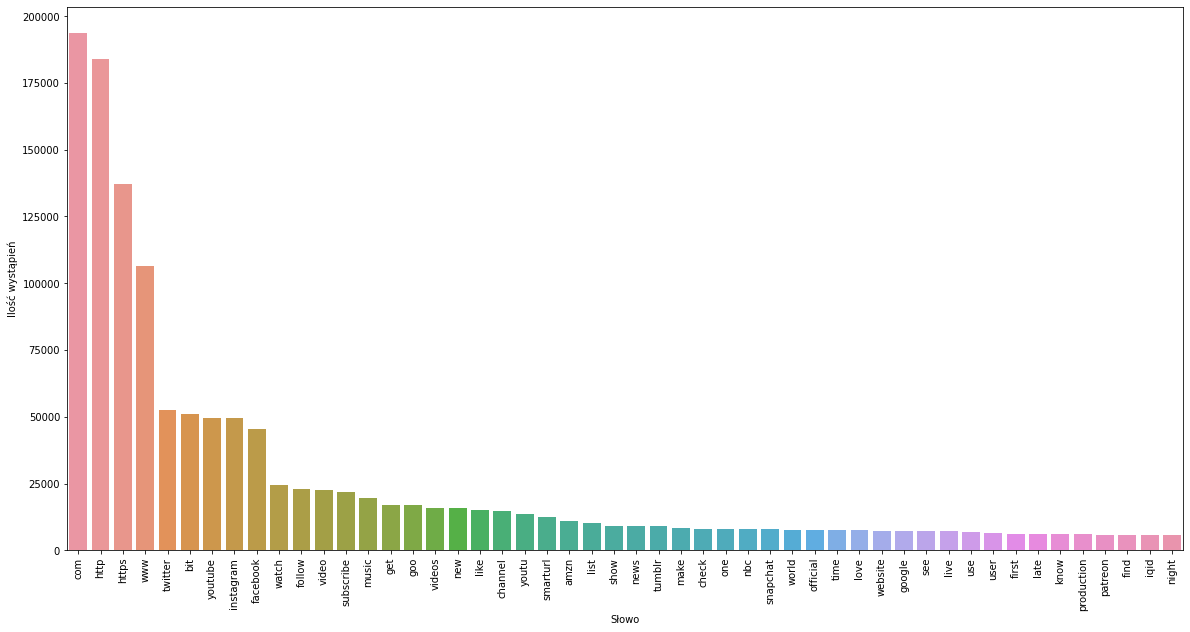

In [42]:
frequency_words(content[content['country_code'] == 'US']['description'])

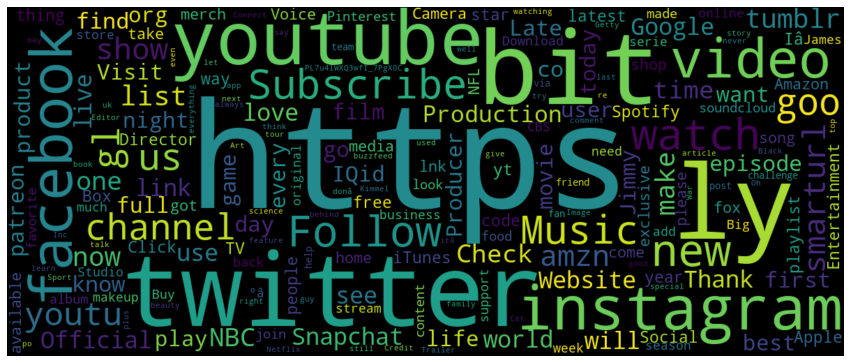

In [43]:
plt_word_cloud(content[content['country_code'] == 'US']['description'])

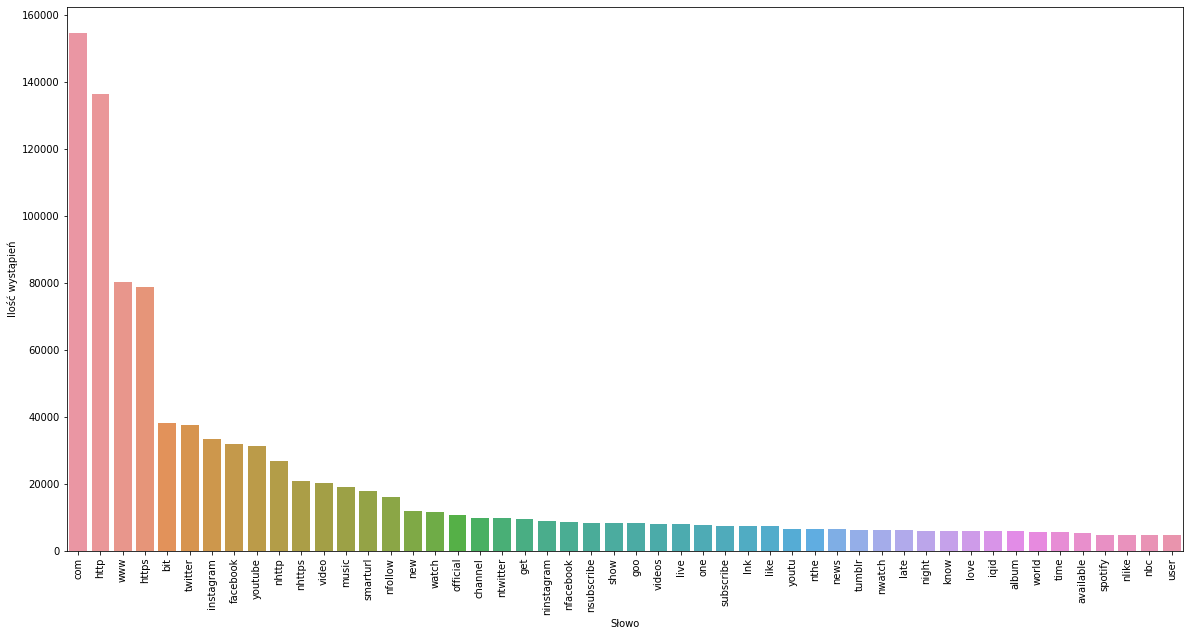

In [44]:
frequency_words(content[content['country_code'] == 'GB']['description'])

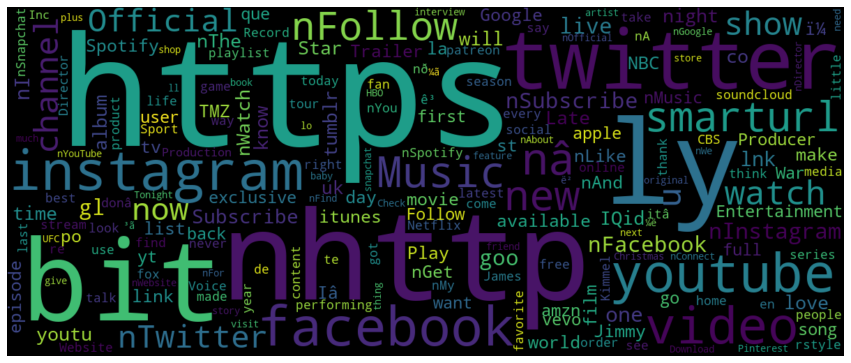

In [45]:
plt_word_cloud(content[content['country_code'] == 'GB']['description'])

Dla tytułów dominuje `official`, `music`, `video`, `trailer` a także `makeup` czy `challenge`. Podobne charakterystyki możemy zaobserować w przypadku słów kluczowych. Mamy do czynienia także z nawiązaniami do wydarzeń które miały miejsce w czasie zbierania danych (chociażby `christmas`). 

Nie obyło się bez nawiązań do premier filmowych i zwiastunów. Najlepszym przykładem jest `Gwiezdne wojny: Ostatni Jedi` który miał swoją premierę 9 grudnia 2017r.

W przypadku opisów dominują linki do profili i mediów społecznościowych (Facebook, Twitter, YouTube, Instagram) czy inne linki (https, bit.ly). Pojawia się też wątek rozrywki czy zachęcenia do subskrybowania.

In [0]:
no_duplicated = content.drop_duplicates(subset='video_id', keep='first', inplace=False)
def show_category_graph(df):
    plt.figure(figsize=(10, 10))
    plt.xticks(rotation=90)
    group = df[df.category_id != np.nan].groupby('category_id').agg(total_videos=pd.NamedAgg(column='category_id', aggfunc='count')).reset_index().sort_values('total_videos', ascending=False).set_index('category_id')
    _ = sns.barplot(group.index.values, group['total_videos'], order=group.index.values).set(
        xlabel = 'Category ID',
        ylabel = 'Liczba filmów'
    )

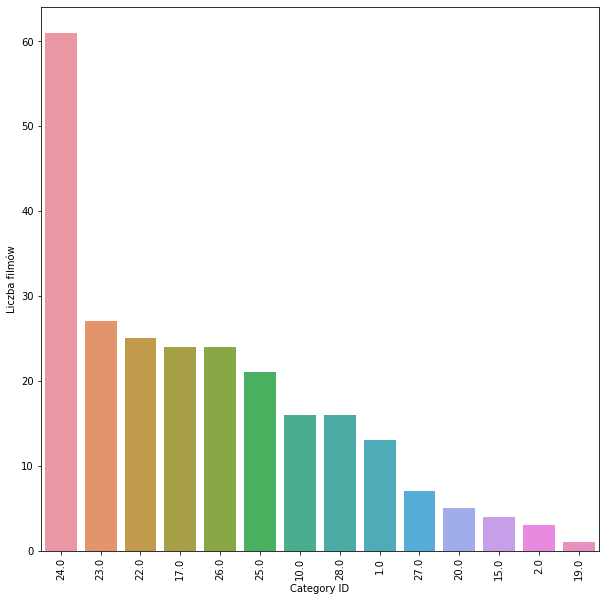

In [47]:
show_category_graph(no_duplicated[no_duplicated['country_code'] == 'US'])

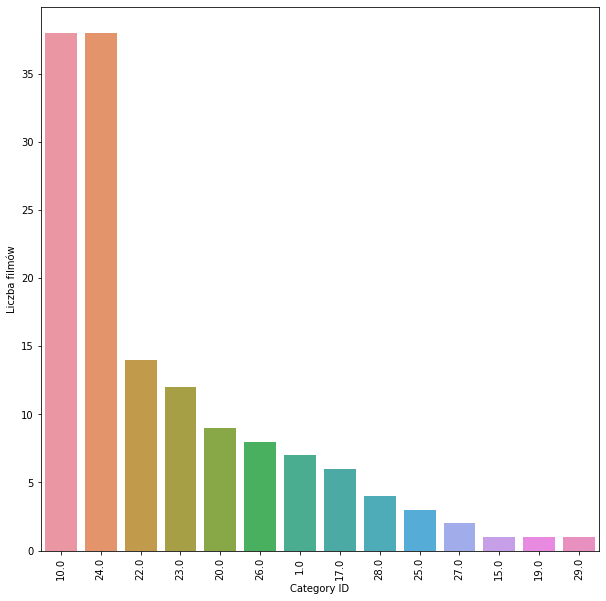

In [49]:
show_category_graph(no_duplicated[no_duplicated['country_code'] == 'GB'])

W przypadku kategorii (nie dysponujemy przypisaniem kategorii dla wszystkich elementów w zbiorze danych - w analizie wykorzystano tylko te dane, które miały wskazane kategorie) dominują:
- w przypadku US: rozrywka
- Dla GB: rozrywka oraz muzyka

Ostatnim krokiem w naszej analizie jest charakterystka korelacji pomiędzy atrybutami.

In [0]:
def show_correlation(df):
    plt.figure(figsize = (25, 15))
    sns.heatmap(df.corr(), annot=True)
    plt.show()

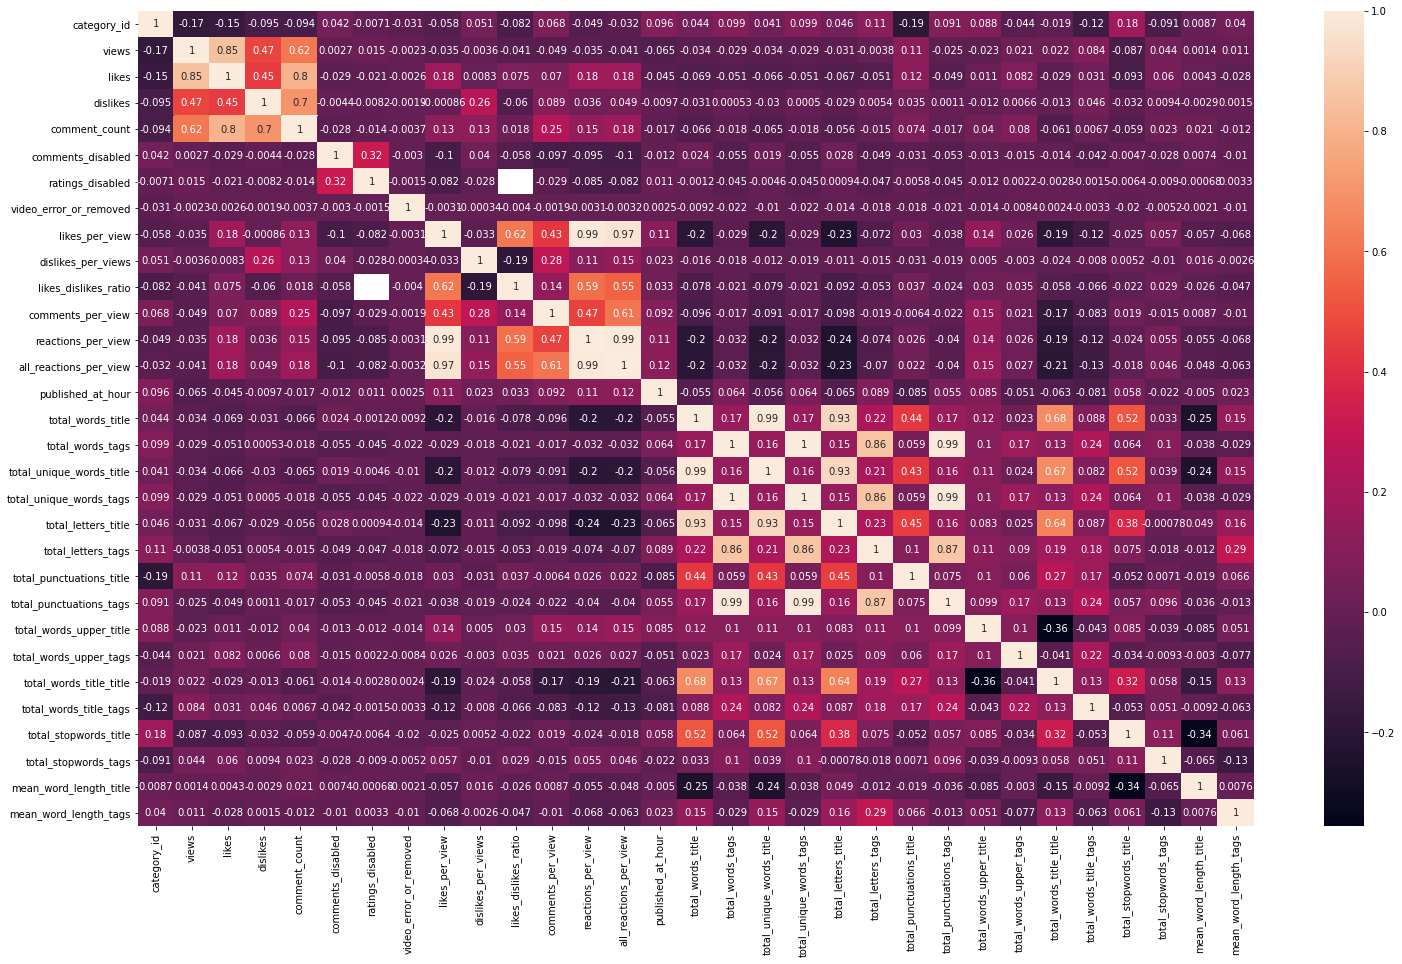

In [51]:
show_correlation(content[content['country_code'] == 'US'])

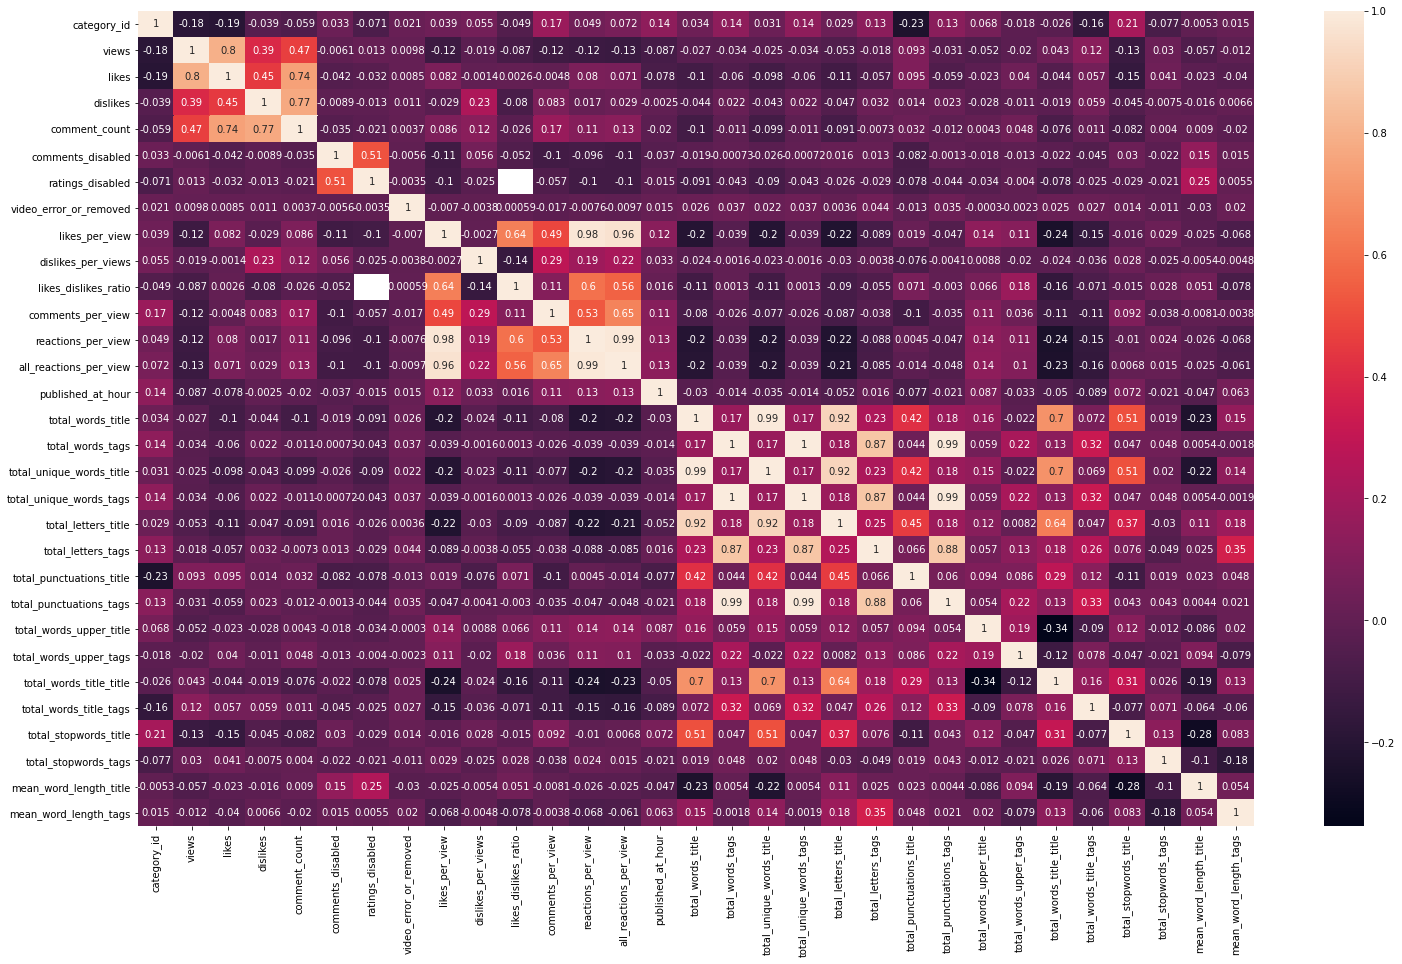

In [52]:
show_correlation(content[content['country_code'] == 'GB'])

Po analizie korelacji między atrybutami, zgodnie z naszymi wcześniejszymi stwierdzeniami warto:
- zrezygnować z wykorzystania atrybutów opisujących liczbę polubień, łapek w dół oraz komentarzy. Zamiast nich warto wykorzystać wprowadzone przez nas atrybuty "normalizujące" wartość w stosunku do liczby wyświetleń (normalnie dużo wyświetleń to dużo polubień, a tak mamy stosunek wskazujący na pewnego rodzaju ocenę jakości materiału)
- nie warto korzystać z liczby unikalnych słów w tytule ani słowach kluczowych - w prawie każdym przypadku nie doszło do powielenia słów (unikalność)
- wskazać, że zachodzi silna zależność wyłączenia komentarzy oraz oceny filmu
- nie korzystać ze stosunku polubienia w stosunku do łapek w dół

# Wnioski

Dokonując analizy danych nie sposób nie wskazać pewnych oczekiwanych, brakujących danych. W naszym przypadku doszliśmy do wniosku o możliwym pozytywnym wpływie danych w postaci:
*   Długość materiału video przesłanego przez użytkownika. Spodziewamy się, że materiały mające długość w zakresie od 3 do 10 min powinny dominować w zbiorze trending videos.
*  Data publikacji a sezonowość. W przypadku świąt jak chociażby Święta Bożego Narodzenia lub Święto Dziękczynienia w USA, video nawiązujące do wskazanego tematu najprawdopodobniej będą dominować zbiór trending videos. Na to przekłada się również sezonowość użytych tagów.

Ponadto, dysponujemy wyłącznie zbiorem danych wskazującym na filmy oznaczone jako trending. Brakuje nam informacji w postaci zbioru danych dla filmów, które nie zostały w tej sposób wyróżnione, aby móc jasno wskazać różnice pomiędzy nimi.

# TODO
- przeanalizować tekst czy nie ma błędów
- zrobić krótkie podsumowanie we wnioskach zgodnie z wymaganiami etapu (co użyć, czego nie, na co trafiliśmy)
- wskazac co warto uzywac za slow tj. trailer, official, video